# **Classificando Avaliações de Filmes usando LSTM**
-------

## Introdução

Processamento de Linguagem Natural é um ramo da Inteligência Artificial que lida com a ponte entre as máquinas que entendem os humanos em sua Linguagem Natural. 

Análise de sentimento é a classificação da opinião ou expressão das pessoas em diferentes sentimentos. Os sentimentos incluem positivo ou negativo, avaliações de resenhas/críticas, feliz ou triste, etc. A análise de sentimento pode ser feita em diferentes indústrias centradas no consumidor para analisar a opinião das pessoas sobre um determinado produto ou assunto. 

IMDb (Internet Movie Database) é um banco de dados online de informações relacionadas a filmes, programas de televisão, vídeos caseiros, videogames e streaming de conteúdo online - incluindo elenco, equipe de produção e biografias pessoais, resumos de enredo, curiosidades, classificações, fãs e análises críticas. Esse dataset é um dos mais famosos para modelos de classificação de textos.

Redes neurais recorrentes, do qual LSTMs (unidades de "memória de longo prazo") é o subconjunto mais poderoso e bem conhecido, são um tipo de rede neural artificial projetada para reconhecer padrões em sequências de dados, tais como dados de séries temporais numéricas de sensores e mercados de ações, além de também reconhecer sequência de texto, genomas, caligrafia e palavra falada. É uma ótima ferramenta para estudar análise de sentimentos.


## Objetivo

O objetico é criar um analisador de resenhas que possa classificar as críticas dos filmes em positiva ou negativa usando redes neurais do tipo LSTM.

## Dataset

O dataset utilizado é uma versão do imbd com o conteúdo das críticas traduzidas para o português.

Link do dataset: <a href="https://www.kaggle.com/luisfredgs/imdb-ptbr" target="_blanck">Kaggle - IMDB PT-BR <a/>


## 1. Importando as Bibliotecas e os Dados



In [71]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report 

import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SpatialDropout1D,LSTM

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
import re


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [97]:
imdb = pd.read_csv("/content/imdb-reviews-pt-br.csv")
print(f"Número de linhas:{imdb.shape[0]}. Número de colunas:{imdb.shape[1]}")
imdb.head()

Número de linhas:49459. Número de colunas:4


,id,text_en,text_pt,sentiment
0,1,Once again Mr. Costner has dragged out a movie...,"Mais uma vez, o Sr. Costner arrumou um filme p...",neg
1,2,This is an example of why the majority of acti...,Este é um exemplo do motivo pelo qual a maiori...,neg
2,3,"First of all I hate those moronic rappers, who...","Primeiro de tudo eu odeio esses raps imbecis, ...",neg
3,4,Not even the Beatles could write songs everyon...,Nem mesmo os Beatles puderam escrever músicas ...,neg
4,5,Brass pictures movies is not a fitting word fo...,Filmes de fotos de latão não é uma palavra apr...,neg


## 2. Preprocessando os Textos

O dataset possui 4 colunas, porém só nos interessa duas delas, a coluna das críticas em português e a coluna do sentimento associado à crítica. Portanto, podemos exluir as outras duas.

In [98]:
imdb = imdb.drop(['id','text_en'],axis=1)
imdb

,text_pt,sentiment
0,"Mais uma vez, o Sr. Costner arrumou um filme p...",neg
1,Este é um exemplo do motivo pelo qual a maiori...,neg
2,"Primeiro de tudo eu odeio esses raps imbecis, ...",neg
3,Nem mesmo os Beatles puderam escrever músicas ...,neg
4,Filmes de fotos de latão não é uma palavra apr...,neg
...,...,...
49454,"Como a média de votos era muito baixa, e o fat...",pos
49455,O enredo teve algumas reviravoltas infelizes e...,pos
49456,Estou espantado com a forma como este filme e ...,pos
49457,A Christmas Together realmente veio antes do m...,pos


Em posse dos dados de interesse, temos que limpar os textos para facilitar o modelo no reconhecimento das palvras. Para isso vamos quebrar as frases, tirar acentuações, números, possíveis url, e colocar todoas as palavras em minúscula. 

Além disso, existem palavras ditas vazias pois não transmitem informações, as chamadas 'stopwords'. Tais palavras precissam ser eliminadas dos textos. Exemplos: as, e, os, de, para, com, sem, foi.

Vamos então criar uma função que realize todas essas funções citadas.

In [99]:
def text_cleaning(text):
    forbidden_words = set(stopwords.words('portuguese'))
    if text:
        text = ' '.join(text.split('.'))
        text = re.sub('\/',' ',text)
        text = re.sub(r'\\',' ',text)
        text = re.sub(r'((http)\S+)','',text)
        text = re.sub(r'\s+', ' ', re.sub('[^A-Za-z]', ' ', text.strip().lower())).strip()
        text = re.sub(r'\W+', ' ', text.strip().lower()).strip()
        text = [word for word in text.split() if word not in forbidden_words]
        return text

In [100]:
# aplica a função text_cleaning nas críticas
imdb['text_pt'] = imdb['text_pt'].apply(lambda x: ' '.join(text_cleaning(x)))

## 3. Dividindo os Dados

Vamos dividir os dados em conjunto de treino e de teste. Temos que também alterar os rótulos das classificações de categóricas (neg, pos) para numérica (0,1), uma vez que o modelo trabalha melhor com números.

In [101]:
X = imdb['text_pt']
y = pd.get_dummies(imdb['sentiment']).values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1, random_state = 17)

Abaixo exibimos o tamanho (linhas, colunas) para as variáveis X e y dos conjuntos de treino e de teste.

In [102]:
print("Treino: ", X_train.shape,y_train.shape)
print("Teste: ", X_test.shape,y_test.shape)

Treino:  (44513,) (44513, 2)
Teste:  (4946,) (4946, 2)


## 4. Tokenização

In [103]:
# defini valores das constantes que serão usadas
max_fatures = 2000
embed_dim = 128
lstm_out = 196
batch_size = 256

Dada uma sequência de caracteres textuais e uma unidade de documento, a tokenização é a tarefa de dividi-la em pedaços, chamados de tokens. O processo é chamado de Tokenização. 

O objeto 'tokenizer' crie tokens para cada palavra no corpus de dados e mapeie-os para um índice usando um dicionário, que pode ser usado para converter qualquer palavra em uma chave no dicionário (número). 

In [104]:
tokenizer = Tokenizer(num_words=max_fatures, split=' ')
tokenizer.fit_on_texts(X_train.values)


Como vamos construir um modelo de sequência, devemos alimentá-lo com uma sequência de números criadas pelo tokenizer. Também devemos garantir que não haja variação nas formas de entrada das sequências. Tudo deve ser do mesmo comprimento. Mas os textos nas resenhas tem diferentes contagens de palavras. Para evitar isso usamos o 'pad_sequence', que fará com que toda a sequência tenha um comprimento constante.

In [105]:
X_train = pad_sequences(tokenizer.texts_to_sequences(X_train.values))
X_test = pad_sequences(tokenizer.texts_to_sequences(X_test.values))

## 5. Criando o Modelo

A seguir, arquitetamos o modlo de rede LSTM.

In [106]:
model = Sequential()
model.add(Embedding(max_fatures, embed_dim,input_length = X_train.shape[1]))
model.add(SpatialDropout1D(0.4))
model.add(LSTM(lstm_out, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(2,activation='softmax'))
model.compile(loss = 'categorical_crossentropy', optimizer='adam',metrics = ['accuracy'])
print(model.summary())

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 464, 128)          256000    
_________________________________________________________________
spatial_dropout1d_3 (Spatial (None, 464, 128)          0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 196)               254800    
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 394       
Total params: 511,194
Trainable params: 511,194
Non-trainable params: 0
_________________________________________________________________
None


Dos dados de teste, vamos parcioná-los para criar um conjunto de validação do modelo.

Em seguida, treinamos o modelo.

In [107]:
validation_size = 2000

X_validate = X_test[-validation_size:]
y_validate = y_test[-validation_size:]
X_test = X_test[:-validation_size]
y_test = y_test[:-validation_size]

In [108]:
# treina e ajusta o modelo com os dados de treino e validação
history = model.fit(X_train, y_train, epochs = 8, batch_size=batch_size, validation_data=(X_validate,y_validate))

Epoch 1/8
174/174 [==============================] - 323s 2s/step - loss: 0.4654 - accuracy: 0.7843 - val_loss: 0.2984 - val_accuracy: 0.8760
Epoch 2/8
174/174 [==============================] - 318s 2s/step - loss: 0.3106 - accuracy: 0.8709 - val_loss: 0.3005 - val_accuracy: 0.8775
Epoch 3/8
174/174 [==============================] - 315s 2s/step - loss: 0.3024 - accuracy: 0.8748 - val_loss: 0.2903 - val_accuracy: 0.8805
Epoch 4/8
174/174 [==============================] - 311s 2s/step - loss: 0.2844 - accuracy: 0.8826 - val_loss: 0.3031 - val_accuracy: 0.8775
Epoch 5/8
174/174 [==============================] - 313s 2s/step - loss: 0.2761 - accuracy: 0.8860 - val_loss: 0.3011 - val_accuracy: 0.8735
Epoch 6/8
174/174 [==============================] - 311s 2s/step - loss: 0.2685 - accuracy: 0.8887 - val_loss: 0.3068 - val_accuracy: 0.8775
Epoch 7/8
174/174 [==============================] - 310s 2s/step - loss: 0.2609 - accuracy: 0.8925 - val_loss: 0.3017 - val_accuracy: 0.8790
Epoch 

Para cada ciclo(epochs) de treino, o modelo mostra a acurácia e a função de perda (relacionada com o erro do modelo). Vamos criar gráficos com esses valores.

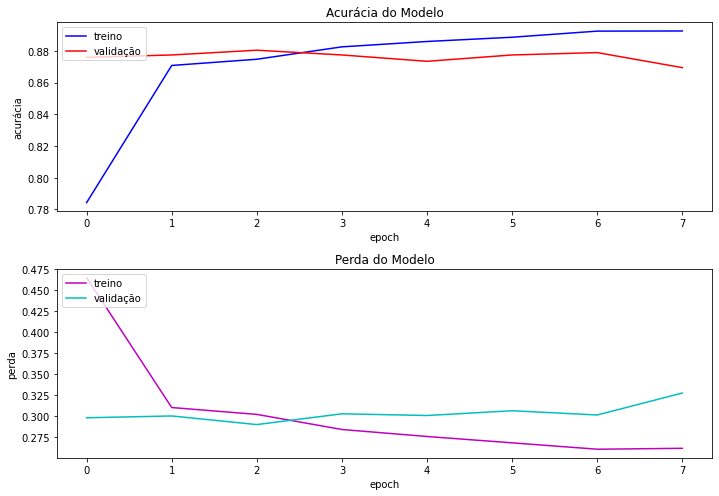

In [111]:
s, (at, al) = plt.subplots(2,1,figsize=(10,7))
at.plot(history.history['accuracy'], c= 'b')
at.plot(history.history['val_accuracy'], c='r')
at.set_title('Acurácia do Modelo')
at.set_ylabel('acurácia')
at.set_xlabel('epoch')
at.legend(['treino', 'validação'], loc='upper left')

al.plot(history.history['loss'], c='m')
al.plot(history.history['val_loss'], c='c')
al.set_title('Perda do Modelo')
al.set_ylabel('perda')
al.set_xlabel('epoch')
al.legend(['treino', 'validação'], loc='upper left')
plt.tight_layout()
plt.show()

Dos gráficos acima vemos que conseguimos aumentar a acurácia (acima de 86%) e diminuir a perda do modelo (abaixo de 33%) tanto para o conjunto de teino quanto para o de validação. Isso é um bom indicativo de que nosso modelo possa funcionar bem.

## 6. Avaliando o Modelo

Nessa parte vamos realizar testes para verificar a qualidade do modelo. Primeiro vamos usar os dados de teste para verificar a acurácia e a perda.

In [113]:
loss, acc = model.evaluate(X_test, y_test, batch_size = batch_size,verbose=2)
print("Perda: %.2f" % (loss))
print("Acurácia: %.2f" % (acc))

12/12 - 3s - loss: 0.3314 - accuracy: 0.8693
Perda: 0.33
Acurácia: 0.87


Temos portanto um modelo com 87% de acurácia e perda (erro) de 33% na classificação de novas resenhas.

Próximo passo é tentar fazer uma classificação direto das resenhas de teste, ou seja, ver se o modelo consegue prever se as resenhas são positivas(1) ou negativas(0).

In [114]:
# transforma o resultado da previsão em 0 ou 1
def decode_sentiment(score):
    return 1 if score>0.5 else 0

# previsão da classificação
scores = model.predict(X_test, verbose=1)
y_pred = [decode_sentiment(score[1]) for score in scores]

93/93 [==============================] - 19s 202ms/step


Para avaliar as previsões vamos fazer uma matriz de confusão, onde podemos comparar a classificação prevista com a real. Também vamos calcular a precisão dos resultados.

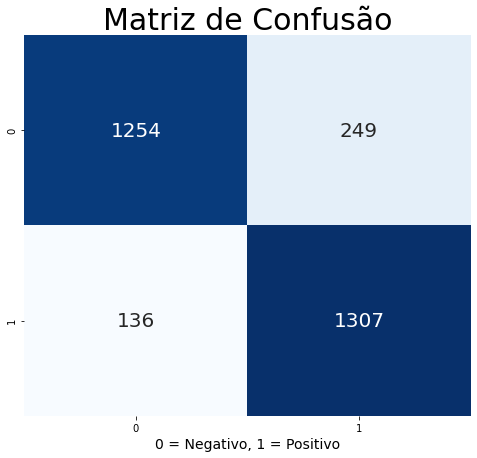

              precision    recall  f1-score   support

           0       0.90      0.83      0.87      1503
           1       0.84      0.91      0.87      1443

    accuracy                           0.87      2946
   macro avg       0.87      0.87      0.87      2946
weighted avg       0.87      0.87      0.87      2946



In [117]:
plt.subplots(figsize=(8,7))
sns.heatmap(confusion_matrix(y_test[:,1], y_pred),annot=True, fmt="1.0f",
            cbar=False,annot_kws={"size": 20},cmap=plt.cm.Blues)
plt.title("Matriz de Confusão",fontsize=30)
plt.xlabel(f"0 = Negativo, 1 = Positivo",fontsize=14)
plt.show()

print(classification_report(y_test[:,1], y_pred))

Dos resultados vemos que temos uma precisão de 90% em classificar as resenhas negativas e uma precisão de 84% na classificação das positivas. Temos portanto um modelo que desempenha sua função muito bem.

## 7. Testando o Modelo e Fazendo uma Classificação

Como teste final, podemos criar frases de exemplos de resenhas e verificar se o modelo consegue classificá-las corretamente em 'positivo' ou 'negativo'.

Para isso temos que criar uma função que transforme a frase inserida em um token, exatamente como fizemos com as resenhas usadas como treino e teste.

In [118]:
def sentimental(tx):
  texto = [tx]
  
  texto = tokenizer.texts_to_sequences(texto)
  texto = pad_sequences(texto, maxlen=30, dtype='int32')

  sentiment = model.predict(texto,batch_size=1,verbose = 2)[0]
  if(np.argmax(sentiment) == 0):
      return "Negativo"
  elif (np.argmax(sentiment) == 1):
       return "Positivo"


Podemos agora inserir duas frases de resenha e ver a saída do modelo.

In [121]:
frase1 = 'Uma grande decepção para o que foi apresentado como um filme incrível. Incrivelmente ruim.'

sentimental(t)

1/1 - 0s


'Negativo'

In [120]:
frase2 = 'Adorei o filme, vou assistir mais vezes'

sentimental(p)

1/1 - 0s


'Positivo'

## 8. Conclusão

O objetivo foi realizado com sucesso. Conseguimos criar um modelo de rede neural usando LSTM que classifica as resenhas em português de filmes em positiva ou negativa.